In [66]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [49]:
# STEP 0: Load the data
# ---------------------------
data_path = "../data/cps_clean_v3.csv"
df = pd.read_csv(data_path)
# Filter out rows where 'OCC' equals 0
df = df[df['OCC'] != 0]
df = df[df['INCZERO_TWO'] == 0]

In [51]:
# Remove columns with more than 100,000 missing values
columns_to_drop = df.columns[df.isnull().sum() > 100000]
df = df.drop(columns=columns_to_drop)

# Remove any rows with missing values
df = df.dropna()

In [50]:
for col in df.columns:
    cardinality = df[col].nunique()
    missing = df[col].isnull().sum()
    print(f"Column: {col}, Cardinality: {cardinality}, Missing values: {missing}")

Column: YEAR, Cardinality: 14, Missing values: 0
Column: RELATE, Cardinality: 16, Missing values: 0
Column: AGE, Cardinality: 67, Missing values: 0
Column: SEX, Cardinality: 2, Missing values: 0
Column: RACE, Cardinality: 25, Missing values: 0
Column: MARST, Cardinality: 6, Missing values: 0
Column: VETSTAT, Cardinality: 2, Missing values: 0
Column: FAMSIZE, Cardinality: 16, Missing values: 0
Column: NCHILD, Cardinality: 10, Missing values: 0
Column: NCHLT5, Cardinality: 8, Missing values: 0
Column: ELDCH, Cardinality: 77, Missing values: 163199
Column: YNGCH, Cardinality: 75, Missing values: 163199
Column: NSIBS, Cardinality: 10, Missing values: 0
Column: FTYPE, Cardinality: 5, Missing values: 0
Column: FAMKIND, Cardinality: 3, Missing values: 0
Column: FAMREL, Cardinality: 5, Missing values: 0
Column: BPL, Cardinality: 165, Missing values: 0
Column: YRIMMIG, Cardinality: 34, Missing values: 255702
Column: CITIZEN, Cardinality: 5, Missing values: 0
Column: NATIVITY, Cardinality: 5, Mi

In [52]:
# Define the lists of columns as specified
categorical_cols = [
    'RELATE', 'SEX', 'RACE', 'MARST', 'VETSTAT', 'FTYPE', 'FAMKIND', 
    'FAMREL', 'CITIZEN', 'NATIVITY', 'HISPAN', 'EMPSTAT', 'LABFORCE', 
    'CLASSWKR', 'WKSTAT', 'SCHLCOLL', 'DIFFHEAR', 'DIFFEYE', 'DIFFREM', 
    'DIFFPHYS', 'DIFFMOB', 'DIFFCARE', 'DIFFANY', 'CLASSWLY', 'WORKLY', 
    'FULLPART', 'PENSION', 'MIGRATE1', 'DISABWRK', 'QUITSICK'
]

embedding_cols = ['BPL', 'OCC', 'IND', 'OCCLY', 'INDLY']
target_cols = ['INCLOG_DELTA']
auxiliary_cols = ['YEAR', 'INCPER_DELTA', 'INCZERO_TWO']

# 1. DataFrame for categorical features with one-hot encoding
for col in categorical_cols:
    df[col] = pd.factorize(df[col])[0]

categorical_features_df = pd.get_dummies(
    df[categorical_cols],
    columns=categorical_cols,
    prefix=categorical_cols
)

# 2. DataFrame for embedding features
for col in embedding_cols:
    df[col] = pd.factorize(df[col])[0]

embedding_df = df[embedding_cols].copy()

# 3. DataFrame for the target variable
target_df = df[target_cols].copy()

# 4. DataFrame for auxiliary features
auxiliary_df = df[auxiliary_cols].copy()

# 5. DataFrame for numerical features: remaining columns
# Identify all columns that are not in any of the lists above.
all_used_cols = set(categorical_cols + embedding_cols + target_cols + auxiliary_cols)
remaining_numeric_cols = [col for col in df.columns if col not in all_used_cols]

# Initialize the scaler and transform the data for these remaining columns.
scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df[remaining_numeric_cols])
numeric_features_df = pd.DataFrame(scaled_numeric_data, columns=remaining_numeric_cols, index=df.index)

# For illustration, print the shapes of the produced DataFrames.
print("Categorical features shape:", categorical_features_df.shape)
print("Embedding features shape:", embedding_df.shape)
print("Target shape:", target_df.shape)
print("Auxiliary features shape:", auxiliary_df.shape)
print("Numeric features shape:", numeric_features_df.shape)

Categorical features shape: (297117, 148)
Embedding features shape: (297117, 5)
Target shape: (297117, 1)
Auxiliary features shape: (297117, 3)
Numeric features shape: (297117, 40)


In [67]:
# List of embedding columns
embedding_cols = ['BPL', 'OCC', 'IND', 'OCCLY', 'INDLY']

# Create input layers and embedding layers for each embedding column.
embedding_inputs = {}   # To store each column's Input layer
embedding_outputs = []  # To store each column's flattened embedding output

for col in embedding_cols:
    # Calculate the cardinality from embedding_df and the embed dimension as half (rounded up).
    cardinality = embedding_df[col].nunique()
    embed_dim = math.ceil(cardinality / 2)
    
    # Create input for the column (each input is a single integer)
    inp = Input(shape=(1,), name=col + "_input")
    
    # Build the embedding layer.
    # Note: We use 'cardinality' as input_dim. Since factorization usually encodes classes as 0 .. cardinality-1,
    # this is sufficient.
    embed = Embedding(input_dim=cardinality, output_dim=embed_dim, input_length=1, name=col + "_embedding")(inp)
    flat_embed = Flatten(name=col + "_flatten")(embed)
    
    embedding_inputs[col] = inp
    embedding_outputs.append(flat_embed)

# Create input layers for numeric and categorical features.
numeric_input = Input(shape=(numeric_features_df.shape[1],), name="numeric_input")
categorical_input = Input(shape=(categorical_features_df.shape[1],), name="categorical_input")

# Concatenate all features: one-hot encoded categorical, normalized numeric and all embeddings.
combined_features = Concatenate(name="combined_features")([categorical_input, numeric_input] + embedding_outputs)

# Add hidden layers
x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear', name='output')(x)

# Build the model. Note the order of inputs must correspond to how we pass them during training.
all_inputs = [numeric_input, categorical_input] + list(embedding_inputs.values())
model = Model(inputs=all_inputs, outputs=output)

def custom_mae_power(y_true, y_pred):
    # Compute mean absolute error, then raise it to the power of 0.8.
    mae = K.mean(K.abs(y_true - y_pred))
    return mae ** 0.8

# Compile the model using mean absolute error as the loss function.
model.compile(optimizer='adam', loss=custom_mae_power, metrics=['mae'])
model.summary()

C:\Users\nickb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ BPL_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCC_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ IND_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCCLY_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ INDLY_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ BPL_embedding (Embedding)     │ (None, 1, 83)             │          13,695 │ BPL_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCC_embedding (Embedding)     │ (None, 1, 356)            │         253,116 │ OCC_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ IND_embedding (Embedding)     │ (None, 1, 146)            │          42,486 │ IND_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCCLY_embedding (Embedding)   │ (None, 1, 356)            │         253,472 │ OCCLY_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ INDLY_embedding (Embedding)   │ (None, 1, 146)            │          42,632 │ INDLY_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 148)               │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ BPL_flatten (Flatten)         │ (None, 83)                │               0 │ BPL_embedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCC_flatten (Flatten)         │ (None, 356)               │               0 │ OCC_embedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ IND_flatten (Flatten)         │ (None, 146)               │               0 │ IND_embedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ OCCLY_flatten (Flatten)       │ (None, 356)               │               0 │ OCCLY_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ INDLY_flatten (Flatten)       │ (None, 146)               │               

 Total params: 973,274 (3.71 MB)

 Trainable params: 973,274 (3.71 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Prepare training inputs.
train_inputs = [numeric_features_df, categorical_features_df] + [embedding_df[col] for col in embedding_cols]

In [69]:
# Train the model.
history = model.fit(
    train_inputs,
    target_df,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.2837 - mae: 0.2074 - val_loss: 0.2765 - val_mae: 0.2008
Epoch 2/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2701 - mae: 0.1949 - val_loss: 0.2750 - val_mae: 0.1994
Epoch 3/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2657 - mae: 0.1910 - val_loss: 0.2750 - val_mae: 0.1994
Epoch 4/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2635 - mae: 0.1890 - val_loss: 0.2753 - val_mae: 0.1997
Epoch 5/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2614 - mae: 0.1872 - val_loss: 0.2762 - val_mae: 0.2005
Epoch 6/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2589 - mae: 0.1848 - val_loss: 0.2764 - val_mae: 0.2007


In [70]:
# After training your model, compute predictions on your training data (or a hold-out set)
preds = model.predict(train_inputs)
# Ensure target values are in an array format
y_true = target_df.values

# Compute residuals: actual - predicted
residuals = y_true - preds

9285/9285 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


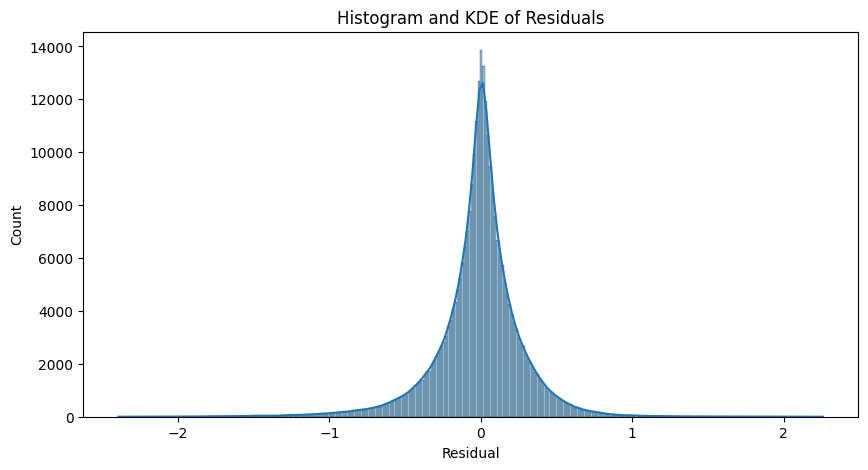

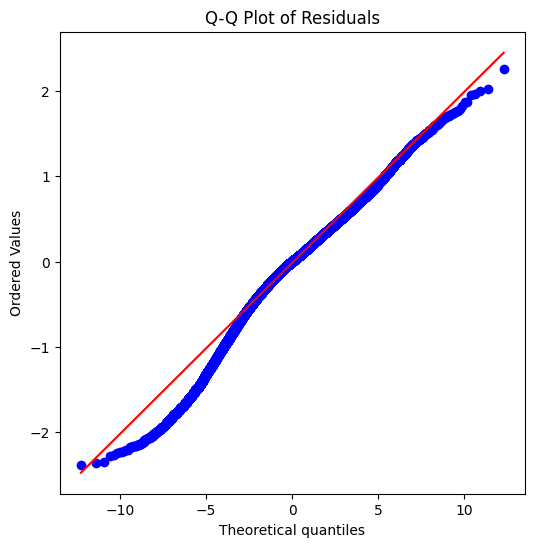

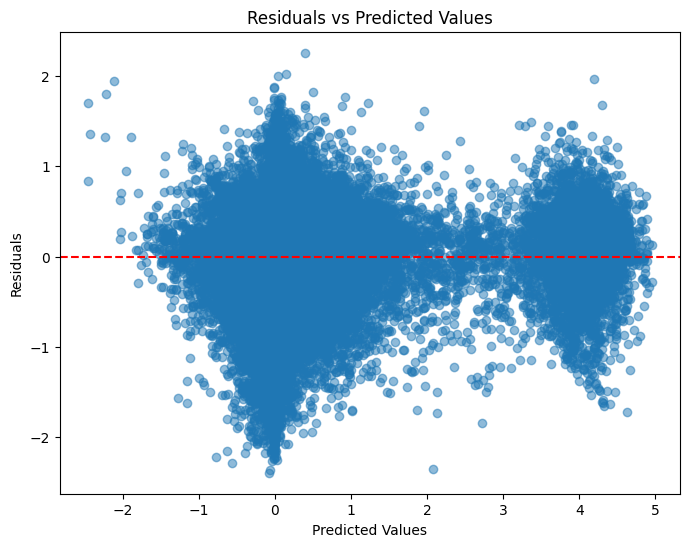

In [79]:
# Plot the residual distribution via histogram and kde
plt.figure(figsize=(10, 5))
sns.histplot(residuals.flatten(), bins=300, kde=True)
plt.xlabel("Residual")
plt.title("Histogram and KDE of Residuals")
plt.show()

# Q-Q plot to assess normality of residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals.flatten(), dist="laplace", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Scatter plot of residuals versus predicted values to check for heteroscedasticity or patterns
plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

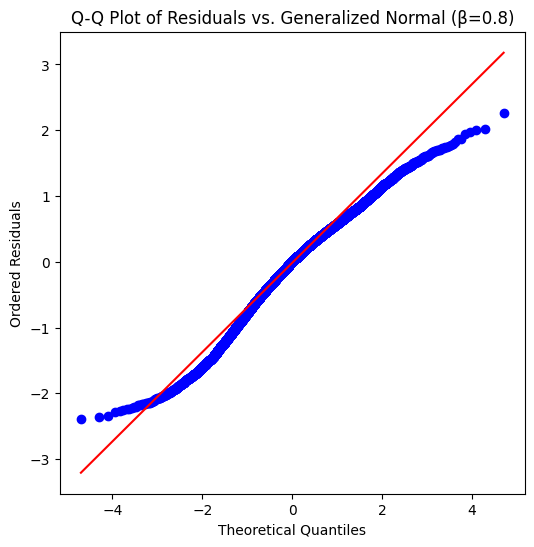

In [78]:
# Assume 'residuals' is a flattened array of your model residuals.
resid = residuals.flatten()

# Estimate location and scale parameters.
# Here, we use the median as a robust estimate of location.
loc = np.median(resid)
# Estimate scale using the mean absolute deviation (a robust measure; note that for β=1 this is optimal for Laplace).
scale = np.mean(np.abs(resid - loc))

plt.figure(figsize=(6, 6))
# Use the generalized normal (gennorm) with β = 0.8 (first parameter) along with loc and scale.
stats.probplot(resid, dist="gennorm", sparams=(0.8, loc, scale), plot=plt)
plt.title("Q-Q Plot of Residuals vs. Generalized Normal (β=0.8)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Residuals")
plt.show()

Fitted parameters:
Shape: 0.8049503219203138
Location: 0.004255736414710651
Scale: 0.13105100185182622


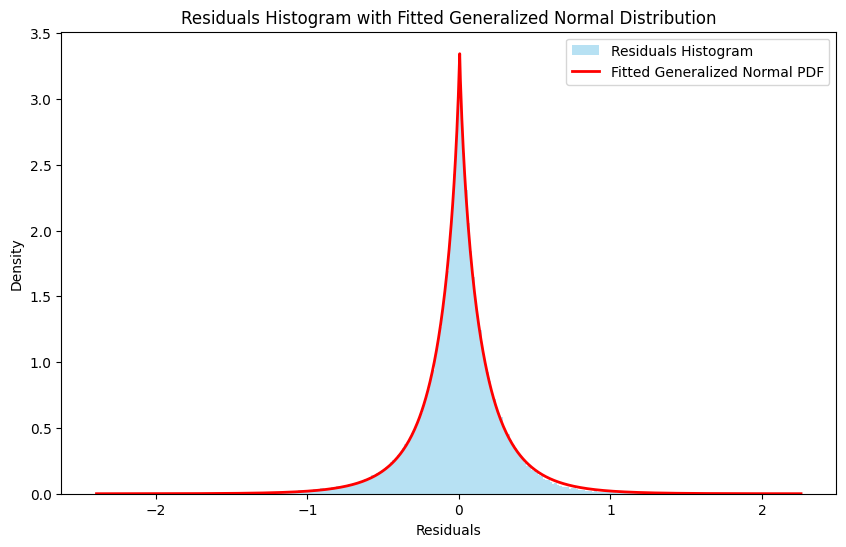

In [72]:
# Fit the generalized normal distribution to the residuals.
# The fit method returns (shape, loc, scale)
shape, loc, scale = stats.gennorm.fit(residuals)
print("Fitted parameters:")
print("Shape:", shape)
print("Location:", loc)
print("Scale:", scale)

# Generate x values spanning the range of residuals.
x = np.linspace(np.min(residuals), np.max(residuals), 1000)

# Compute the fitted generalized normal pdf over x.
fitted_pdf = stats.gennorm.pdf(x, shape, loc=loc, scale=scale)

# Plot a normalized histogram of the residuals and overlay the fitted pdf.
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=300, density=True, alpha=0.6, color="skyblue", label="Residuals Histogram")
plt.plot(x, fitted_pdf, "r-", lw=2, label="Fitted Generalized Normal PDF")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Residuals Histogram with Fitted Generalized Normal Distribution")
plt.legend()
plt.show()

Sample of predicted vs actual values:
      Actual  Predicted
0  -0.591618  -0.129912
1   0.216138   0.098128
2  -0.198050   0.006884
3  -0.393460  -0.156175
4   0.155571  -0.060315
5  -0.317882   0.090923
6  -0.104002  -0.052691
7  -0.054734  -0.037699
8  -0.147247  -0.045486
9   0.013858  -0.262120
10 -0.022883  -0.246851
11  0.705106   0.438549
12 -0.010420  -0.103448
13 -0.066136   0.013527
14  0.002913   0.018571
15 -0.048896   0.020276
16 -0.007092  -0.068239
17 -0.068284  -0.056463
18 -0.080869   0.007747
19  0.458008   0.547435


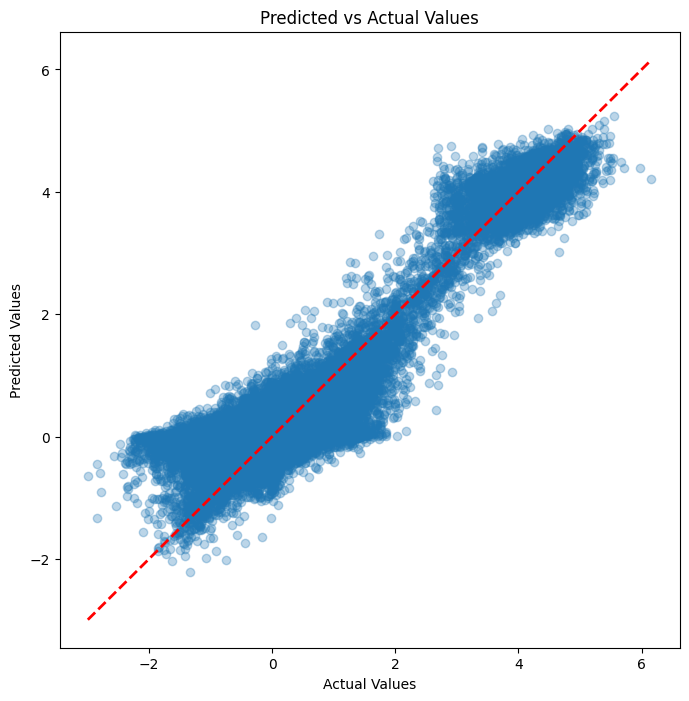

In [75]:
# Create a DataFrame to store a lot of predicted vs actual values.
df_pred_actual = pd.DataFrame({
    'Actual': target_df.values.flatten(),
    'Predicted': predictions.flatten()
})

# Print a sample of the predicted vs actual values (first 20 rows)
print("Sample of predicted vs actual values:")
print(df_pred_actual.head(20))

# Scatter plot to visualize predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(df_pred_actual['Actual'], df_pred_actual['Predicted'], alpha=0.3)
# Plot a red dashed line representing the perfect prediction (i.e. y=x)
min_val = df_pred_actual['Actual'].min()
max_val = df_pred_actual['Actual'].max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

9285/9285 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


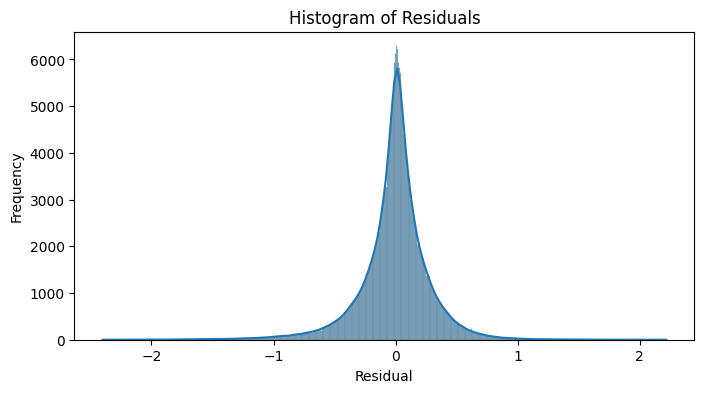

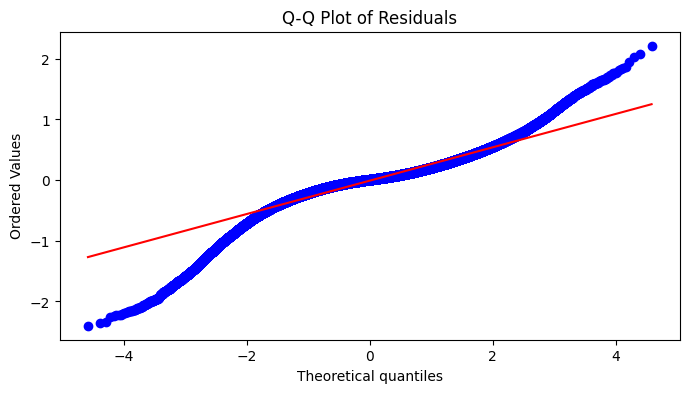

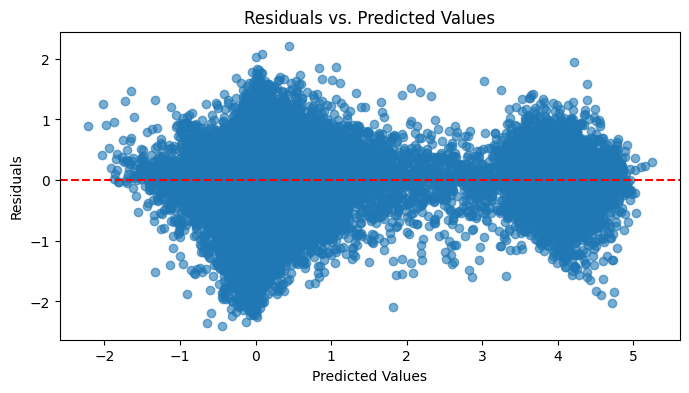

In [57]:
# Get predictions from the model (using training data for demonstration; adjust as needed)
predictions = model.predict(train_inputs)

# Calculate residuals: difference between true and predicted values.
residuals = target_df.values.flatten() - predictions.flatten()

# Plot the histogram of residuals with KDE fit
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Generate a Q-Q plot to compare residuals against a normal distribution
plt.figure(figsize=(8, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Plot residuals vs. predicted values to check for homoscedasticity
plt.figure(figsize=(8, 4))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [17]:
# ---------------------------
# STEP 1: Preprocess the data
# ---------------------------
# Ensure OCC is a 4-digit string (padding with leading zeros if necessary)
df['OCC'] = df['OCC'].astype(str).str.zfill(4)

# Create an integer index for each unique OCC code
df['OCC_code'] = pd.factorize(df['OCC'])[0]

# Identify continuous features; we assume that aside from OCC (and its derived categorical representation)
# one of the columns is the target: INCPER_DELTA.
cols_to_exclude = ['OCC', 'OCC_code', 'INCPER_DELTA', 'INCCHANGE']
continuous_columns = [col for col in df.columns if col not in cols_to_exclude]

print("Number of continuous features:", len(continuous_columns))

# Extract continuous features and target variable
X_cont = df[continuous_columns].values.astype(np.float32)
y = df['INCPER_DELTA'].values.astype(np.float32)

# Standardize continuous features
scaler = StandardScaler()
X_cont = scaler.fit_transform(X_cont)

# Extract OCC code as a separate array
occ_codes = df['OCC_code'].values.astype(np.int32)

# Split the data into training and validation sets
indices = np.arange(len(df))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

occ_code_train = occ_codes[train_idx]
X_cont_train    = X_cont[train_idx]
y_train         = y[train_idx]

occ_code_val   = occ_codes[val_idx]
X_cont_val     = X_cont[val_idx]
y_val          = y[val_idx]

Number of continuous features: 75


In [19]:
# ---------------------------
# Compute initial embedding matrix for OCC using classical MDS on occ_cosine
# ---------------------------
# Set the desired embedding dimension (e.g., 16)
embedding_dim = 32
N = occ_cosine.shape[0]

# Compute the squared distance matrix
D2 = occ_cosine ** 2

# Centering matrix
J = np.eye(N) - np.ones((N, N)) / N

# Compute the Gram matrix (inner products)
B = -0.5 * J.dot(D2).dot(J)

# Eigen-decomposition of B; eigh returns sorted eigenvalues in ascending order, so sort in descending order
e_vals, e_vecs = np.linalg.eigh(B)
idx = np.argsort(e_vals)[::-1]
e_vals = e_vals[idx]
e_vecs = e_vecs[:, idx]

# Take the top `embedding_dim` eigenvalues and eigenvectors.
# (Assume the top eigenvalues are nonnegative; if not, you may clip negative values to 0.)
initial_embedding = e_vecs[:, :embedding_dim] * np.sqrt(e_vals[:embedding_dim])
# Now, initial_embedding has shape (N, embedding_dim)

In [20]:
# ---------------------------
# STEP 2: Build the multi-input Keras model (without alignment loss)
# ---------------------------


# OCC Branch: one input for the full OCC code (as an integer index)
occ_in = Input(shape=(1,), name='occ')

# Embedding layer for OCC with weights initialized using the classical MDS result.
occ_emb = Embedding(input_dim=N, output_dim=embedding_dim,
                    weights=[initial_embedding],
                    name='occ_emb')(occ_in)
occ_emb = Flatten(name='occ_flat')(occ_emb)

# Continuous Features Branch: Process other features as a single input.
cont_input = Input(shape=(X_cont.shape[1],), name='continuous_input')
# Build a context representation using, for example, a Dense layer (e.g., 64 dimensions)
context_rep = Dense(64, activation='relu', name='context_rep')(cont_input)

# Merge the OCC embedding and the continuous context representation via concatenation.
merged = Concatenate(name='merged')([occ_emb, context_rep])

# Final Prediction Branch for the target variable (INCPER_DELTA)
x = Dense(64, activation='relu', name='dense_1')(merged)
x = Dropout(0.1, name='dropout_1')(x)
# x = Dense(32, activation='relu', name='dense_2')(x)
# x = Dropout(0.2, name='dropout_2')(x)
# x = Dense(16, activation='relu', name='dense_3')(x)
# x = Dropout(0.2, name='dropout_3')(x)
target_pred = Dense(1, activation='linear', name='target')(x)

# Create the Keras model
model = Model(inputs=[occ_in, cont_input], outputs=target_pred)
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ occ (InputLayer)              │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ occ_emb (Embedding)           │ (None, 1, 32)             │          22,752 │ occ[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ continuous_input (InputLayer) │ (None, 75)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ occ_flat (Flatten)            │ (None, 32)                │               0 │ occ_emb[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ context_rep (Dense)           │ (None, 64)                │           4,864 │ continuous_input[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ merged (Concatenate)          │ (None, 96)                │               0 │ occ_flat[0][0],            │
│                               │                           │                 │ context_rep[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           6,208 │ merged[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ target (Dense)                │ (None, 1)                 │              65 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 33,889 (132.38 KB)

 Trainable params: 33,889 (132.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# ---------------------------
# STEP 3: Compile and train the model
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse'])

# Prepare inputs for model.fit in the same order as defined in the model
train_inputs = [occ_code_train, X_cont_train]
val_inputs   = [occ_code_val, X_cont_val]

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1599 - mse: 0.0585 - val_loss: 0.1264 - val_mse: 0.0324
Epoch 2/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1263 - mse: 0.0332 - val_loss: 0.1253 - val_mse: 0.0330
Epoch 3/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1254 - mse: 0.0328 - val_loss: 0.1248 - val_mse: 0.0327
Epoch 4/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1242 - mse: 0.0322 - val_loss: 0.1258 - val_mse: 0.0322
Epoch 5/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1244 - mse: 0.0324 - val_loss: 0.1244 - val_mse: 0.0322
Epoch 6/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1240 - mse: 0.0324 - val_loss: 0.1245 - val_mse: 0.0324
Epoch 7/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1237 - mse: 0.0323 - val_loss: 0.1242 - val_mse: 0.0323
Epoch 8/100
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1234 - mse: 0.0322 - val_loss: 0.1245 - val_mse: 0.0321
Epoch 9/100
1955/1955 ━━━━━━━━━━

In [22]:
# ---------------------------
# (Optional) Save the model and scaler
# ---------------------------
model.save("occ_embedding_model_no_align.keras")

1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step


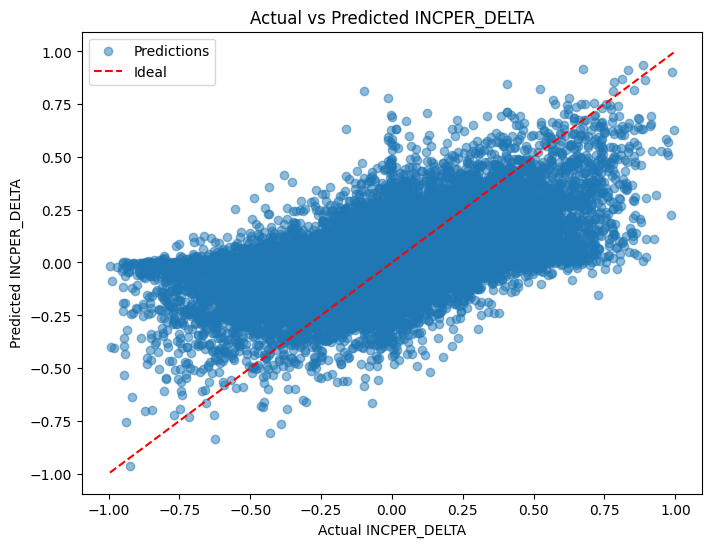

In [23]:
import matplotlib.pyplot as plt

# Generate predictions on the validation set
y_pred = model.predict(val_inputs)

# Plot predicted vs actual INCPER_DELTA
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label='Ideal')  # 45° line
plt.title("Actual vs Predicted INCPER_DELTA")
plt.xlabel("Actual INCPER_DELTA")
plt.ylabel("Predicted INCPER_DELTA")
plt.legend()
plt.show()

1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 852us/step
Baseline MSE: 7.681099e-05
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 779us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 785us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 819us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 812us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 877us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 911us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step
1955/1955 ━━━━━━━━━━━━━━━━━━

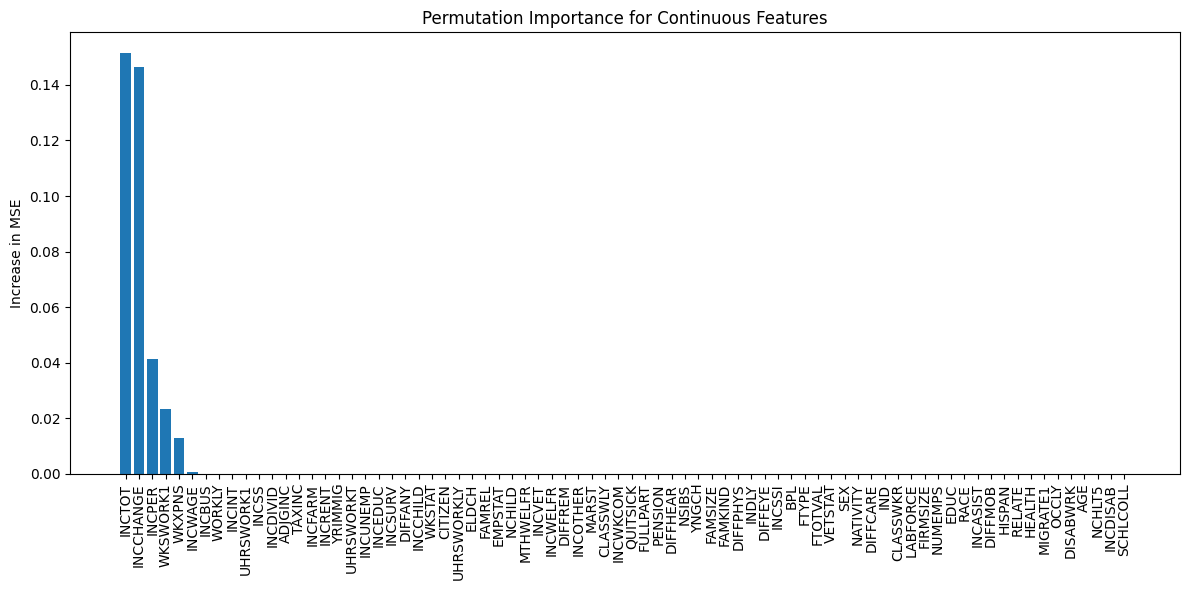

1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step
1955/1955 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step


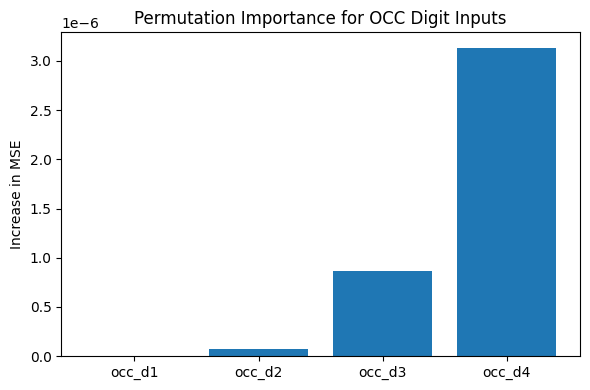

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute baseline performance on the validation set
val_inputs = [occ_d1_val, occ_d2_val, occ_d3_val, occ_d4_val, X_cont_val]
baseline_preds = model.predict(val_inputs)
baseline_mse = mean_squared_error(y_val, baseline_preds)
print("Baseline MSE:", baseline_mse)

# ==============================
# Permutation Importance: Continuous Features
# ==============================
# For each continuous feature, randomly permute that column and compute the new MSE.
cont_importance = []
n_features = X_cont_val.shape[1]

# Save a copy of the original continuous features (so we don't modify the original variable)
X_cont_val_orig = np.copy(X_cont_val)

for i in range(n_features):
    X_cont_perm = np.copy(X_cont_val_orig)
    # Permute column i
    X_cont_perm[:, i] = np.random.permutation(X_cont_perm[:, i])
    # Build new inputs with the permuted continuous feature column,
    permuted_inputs = [occ_d1_val, occ_d2_val, occ_d3_val, occ_d4_val, X_cont_perm]
    permuted_preds = model.predict(permuted_inputs)
    permuted_mse = mean_squared_error(y_val, permuted_preds)
    importance = permuted_mse - baseline_mse
    cont_importance.append(importance)

cont_importance = np.array(cont_importance)

# Plot continuous feature permutation importance
plt.figure(figsize=(12, 6))
# Sort features by importance (largest increase in error on top)
indices = np.argsort(cont_importance)[::-1]
plt.bar(range(n_features), cont_importance[indices])
plt.xticks(range(n_features), np.array(continuous_columns)[indices], rotation=90)
plt.ylabel("Increase in MSE")
plt.title("Permutation Importance for Continuous Features")
plt.tight_layout()
plt.show()

# ==============================
# Permutation Importance: OCC Digit Inputs
# ==============================
# For each of the OCC digit inputs, randomly permute that input and compute the change in MSE.
occ_importance = {}
occ_digit_names = ['occ_d1', 'occ_d2', 'occ_d3', 'occ_d4']
# Prepare a list of the original occ digit arrays for validation
occ_digits = [occ_d1_val, occ_d2_val, occ_d3_val, occ_d4_val]

for i, name in enumerate(occ_digit_names):
    # Create a permuted version of the i-th OCC digit input
    occ_perm = np.copy(occ_digits[i])
    occ_perm = np.random.permutation(occ_perm)
    # Construct new list of occ inputs—replace ith input with permuted values, leave others unchanged
    occ_inputs = [occ_perm if idx == i else occ_digits[idx] for idx in range(4)]
    # Continuous input remains unchanged
    permuted_inputs = occ_inputs + [X_cont_val_orig]
    permuted_preds = model.predict(permuted_inputs)
    permuted_mse = mean_squared_error(y_val, permuted_preds)
    occ_importance[name] = permuted_mse - baseline_mse

# Plot OCC digit importance as a bar chart
plt.figure(figsize=(6, 4))
names = list(occ_importance.keys())
values = [occ_importance[name] for name in names]
plt.bar(names, values)
plt.ylabel("Increase in MSE")
plt.title("Permutation Importance for OCC Digit Inputs")
plt.tight_layout()
plt.show()